# Dynamic Statistics Tool

## Data input

#### Imports

In [1]:
from __future__ import division, print_function
import pandas as pd
import numpy as np
from copy import deepcopy
from datetime import timedelta
from datetime import date
import calendar
from scipy.optimize import curve_fit
from scipy.misc import factorial

%matplotlib inline
import matplotlib.pyplot as plt
import mpld3
mpld3.enable_notebook()
    
files = ["../Data_Acetate/acetateAlarms.csv","../Data_Acetate/acetateAlarmsTr.csv"]

#### Data

In [2]:
def GetData(files,systems=None):
    ''' Read the input data (one or more files, with the possibility to give the data from each file a (different) label). 
        Remove irrelevant entries (alarms being acknowledged or going off / alarms that are not really errors).
        Group the data by ID (ID's of which only one message was recorded, are left out).
    '''
    # Read CSV data
    dfs = [pd.read_csv(f,encoding="utf-8-sig",parse_dates=['Timestamp']) for f in files]
    if systems and len(systems) == len(files):
        for i,x in enumerate(systems):
            dfs[i]['System'] = x
    df = pd.concat(dfs)
    # Remove irrelevant data
    if 'State' in df.columns:            # upcoming alarms (no OFF/ACK)
        df = df[df['State']==1]                                         
        del df['State']
    if 'Class' in df.columns:           # error messages (no System/Tolerance)
        df = df[df['Class']=='Error']
        del df['Class']  
    df.sort_values(by='Timestamp',inplace=True)    
    # Get the time span of the input data 
    timeSpan = [min(df['Timestamp'])-timedelta(seconds=1) , max(df['Timestamp'])+timedelta(seconds=1)]
    # Grouped data (by ID)
    dfs = {x: df[df['Id']==x].copy() for x in set(list(df['Id'])) if len(df[df['Id']==x]) > 1} 
    for key in dfs:
        dfs[key].index = range(len(dfs[key]))
    return dfs, timeSpan

data, dataSpan = GetData(files,["Acetate","Tracing"])

#### Selection

In [3]:
def GetDataSelection(dfs,dfsSpan,today=None,w_from=1,w_till=0):
    ''' Get all data in the specified range of weeks. 
        Starting from 'w_from' weeks ago, till 'w_till' weeks ago.
    '''
    if not today: 
        today = date.today()
    t_from = today - timedelta((w_till + w_from)*7-1)
    t_till = today - timedelta(w_till*7)
    if (t_from > dfsSpan[1].date()) or (t_till < dfsSpan[0].date()):
        print('There is no data of the specified selection. ({} -> {})'.format(t_from,t_till))
        return None
    weeks = w_from + w_till
    if (today-dfsSpan[0].date()).days/7 < weeks:
        weeks = int((today-dfsSpan[0].date()).days/7)
        #print("There isn't data of all the speficied weeks, only {} weeks where selected.".format(weeks))

    dfs_select = deepcopy(dfs)
    for key in sorted(dfs_select):
        dfs_select[key] = dfs_select[key][dfs_select[key]['Timestamp'].map(lambda x: t_from <= x.date() <= t_till)]
        if len(dfs_select[key]) == 0:
            del dfs_select[key]
    return dfs_select,weeks

today = date(2016, 4, 13)
data_prev, weeks_prev = GetDataSelection(data,dataSpan,today,w_from=26,w_till=1)
data_curr, weeks_curr = GetDataSelection(data,dataSpan,today)
dataScale = weeks_prev/weeks_curr

#### Computations

In [4]:
# !Important: If you want to re-run this cell, re-run the previous cell (underneath the title 'Selection') first.

def GetNumberOfMessages(dfs, timeSpan):
    ''' Count for each ID the number of times each message occured per date. 
    ''' 
    dfs_nom = deepcopy(dfs)
    day_f = timeSpan[0].date().replace(day=1)
    day_l = timeSpan[1].date().replace(day=calendar.monthrange(timeSpan[0].date().year,timeSpan[0].date().month)[1])
    days = [day_f + timedelta(days=x) for x in range((day_l-day_f).days+1)]
    for key in dfs_nom:
        dfs_nom[key]['Timestamp'] = dfs_nom[key]['Timestamp'].map(lambda x: x.date())
        dfs_nom[key]['Count'] = dfs_nom[key]['Message'].map(lambda x: 1)
        dfs_nom[key] = dfs_nom[key][['Timestamp','Message','Count']]
        dfs_nom[key] = pd.pivot_table(dfs_nom[key],index=["Timestamp"],columns=["Message"],aggfunc=[np.sum])
        dfs_nom[key].columns = dfs_nom[key].columns.droplevel([0,1])    # remove irrelevant top levels
        dfs_nom[key].replace(np.NaN,0,inplace=True)                     # convert NaN to 0
        for day in days:                                                # fill gaps in time data
            if day not in dfs_nom[key].index:
                dfs_nom[key].loc[day] = [0]*len(dfs_nom[key].columns)
        dfs_nom[key].sort_index(inplace=True)
    return dfs_nom

def GetNumberOfOccurrences(dfs):
    ''' Count for each ID the number of occurrences. 
    '''
    return {key: dfs[key]['Message'].count() for key in dfs}   

def AddPrior(dfs,t_prior):
    ''' Add an entry before and after the data.
    '''
    for key in sorted(dfs):
        for t in t_prior:
            dfs_prior = dfs[key][:1].copy() 
            dfs_prior['Timestamp'] = t
            dfs[key] = pd.concat([dfs[key],dfs_prior])
        dfs[key].sort_values('Timestamp',inplace=True) 
    return

def AddDelta(dfs):
    ''' Add a column holding the time between this entry and the previous one (in hours).
        First add an entry before and after the data.
    '''
    for key in sorted(dfs):
        dfs[key]['Delta'] = dfs[key]['Timestamp'] - dfs[key]['Timestamp'].shift(1)  # calculate time between
        dfs[key] = dfs[key][dfs[key]['Delta'].notnull()]
        dfs[key]['Delta'] = dfs[key]['Delta'].map(lambda x: x.days*24 + x.seconds//3600 + int((x.seconds%3600)/36)/100)
        dfs[key].index = range(len(dfs[key]))
    return

def Poisson(k, lamb):
    ''' Poisson distribution. 
    '''
    return (lamb**k/factorial(k)) * np.exp(-lamb)

def GetPoissonParameters(dfs,bins=False):
    ''' Fit a poisson distribution on the histogram of the data per ID and return the resulting poisson parameters.
    '''
    dfs_pdp = dict()
    for key in dfs:
        deltas = list(dfs[key]['Delta'])
        if not bins:
            bins = int(np.max(deltas))
        entries, bin_edges = np.histogram(deltas,bins)  
        bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])  
        parameters, _ = curve_fit(Poisson, bin_middles, entries, maxfev=1000)
        dfs_pdp[key] = int(parameters[0]*1000)/1000  
    return dfs_pdp

nom = GetNumberOfMessages(data,dataSpan)
noo_prev = GetNumberOfOccurrences(data_prev)
AddPrior(data_prev,dataSpan)
AddDelta(data_prev)
pdp_prev = GetPoissonParameters(data_prev)

noo_curr = GetNumberOfOccurrences(data_curr)
AddPrior(data_curr,dataSpan)
AddDelta(data_curr)
pdp_curr = GetPoissonParameters(data_curr)

/usr/local/lib/python2.7/dist-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


## Tool

#### Scatter Plots

/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


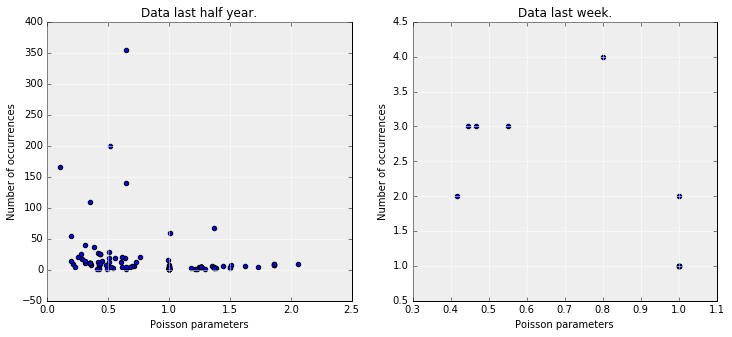

In [5]:
def ScatterPlots(d_prev,d_curr):
    d_prev = list(map(list, zip(*d_prev)))
    d_curr = list(map(list, zip(*d_curr)))
    
    fig, ax = plt.subplots(1,2,subplot_kw=dict(axisbg='#EEEEEE'),figsize=(12,5))
    for i in range(len([d_prev,d_curr])):
        ax[i].grid(color='white', linestyle='solid')
        ax[i].set_xlabel("Poisson parameters")
        ax[i].set_ylabel("Number of occurrences")
        
    ax[0].set_title("Data last half year.")    
    scatter_prev = ax[0].scatter(d_prev[0],d_prev[1])
    tooltip_prev = mpld3.plugins.PointLabelTooltip(scatter_prev, labels=d_prev[2])   
    mpld3.plugins.connect(fig, tooltip_prev)
    ax[1].set_title("Data last week.")    
    scatter_curr = ax[1].scatter(d_curr[0],d_curr[1])
    tooltip_curr = mpld3.plugins.PointLabelTooltip(scatter_curr, labels=d_curr[2])   
    mpld3.plugins.connect(fig, tooltip_curr)  
    return

sca_prev = [[pdp_prev[x] , noo_prev[x], x] for x in pdp_prev]
sca_curr = [[pdp_curr[x] , noo_curr[x], x] for x in pdp_curr]
ScatterPlots(sca_prev,sca_curr)

#### Comparing Plot

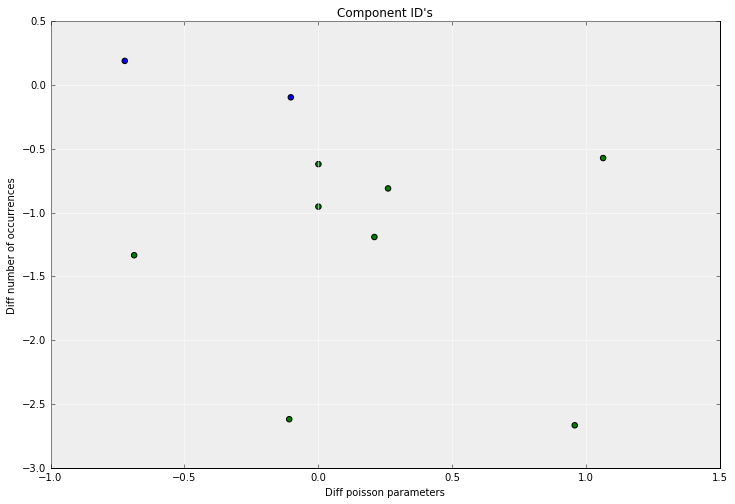

In [6]:
def ComparingPlot(d_scatter):
    ''' Show scatter plot with interactive artists. (hover = show label).
    '''
    colors = ['g' if x[1]< -0.5 else ('b' if x[1]< 0.5 else 'r') for x in d_scatter]
    #colors = ['b' if x[1]==0 else ('g' if x[1]<0 else 'r') for x in d_scatter]
    d_scatter = list(map(list, zip(*d_scatter)))
    fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'),figsize=(12,8))
    ax.grid(color='white', linestyle='solid')
    ax.set_title("Component ID's")
    ax.set_xlabel("Diff poisson parameters")
    ax.set_ylabel("Diff number of occurrences")
    
    scatter = ax.scatter(d_scatter[0],d_scatter[1],c=colors,s=30)
    tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=d_scatter[2])  
    mpld3.plugins.connect(fig, tooltip)
    return

sca_prev_scaled = map(lambda x: (x[0],x[1]/dataScale,x[2]),sca_prev)
compare = [(x[0]-y[0],x[1]-y[1],x[2]) for x in sca_prev_scaled for y in sca_curr if x[2]==y[2]]
ComparingPlot(compare)